In [4]:
import xlwings as xw
from pathlib import Path
import pandas as pd
import numpy as np
import time

from scipy.ndimage import standard_deviation
from tqdm import trange

# ================== CONFIG ==================
RUN_CONFIG = {
    "n_runs": 1000,
    "crest_file": Path(r"E:\CREST Model\CREST_Demand_Model_v2.3.3.xlsm"),
    "output_dir": Path(
        r"E:\GitHubProjects\LV network\Input data\Hotwater"
    ),
    "output_csv_template": "crest_{scenario}_30min.csv",
    "main_sheet": "Main Sheet",
    "dwelling_sheet": "Dwellings",
    "output_sheet": "Results - disaggregated",
    "macro_name": "RunSimulationButton_Click",
    "we_wd_cell": "F7",
    "occupancy_cell": "B5",
    "occupancy_values": [3,4,5],
    "we_wd_values": ["wd"],
    "data_ranges": {
        "hotwater_L": "O7:O1446",
        "occupancy": "D7:D1446",
        "activity": "E7:E1446",
        "appliance_demand_W": "G7:G1446",
        "Thermal Gains_W" : "H7:H1446"
    },
    "resample_freq": "30min",
}
# ============================================

OUTPUT_DIR = RUN_CONFIG["output_dir"]
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

N_RUNS = RUN_CONFIG["n_runs"]
CREST_FILE = RUN_CONFIG["crest_file"]
MAIN_SHEET = RUN_CONFIG["main_sheet"]
DWELLING_SHEET = RUN_CONFIG["dwelling_sheet"]
OUTPUT_SHEET = RUN_CONFIG["output_sheet"]
MACRO_NAME = RUN_CONFIG["macro_name"]
WE_WD_CELL = RUN_CONFIG["we_wd_cell"]
OCCUPANCY_CELL = RUN_CONFIG["occupancy_cell"]
OCCUPANCY_VALUES = RUN_CONFIG["occupancy_values"]
WE_WD_VALUES = RUN_CONFIG["we_wd_values"]
OUTPUT_CSV_TEMPLATE = RUN_CONFIG["output_csv_template"]
DATA_RANGES = RUN_CONFIG["data_ranges"]
RESAMPLE_FREQ = RUN_CONFIG["resample_freq"]

EXPECTED_ROWS = 1440
MINUTE_INDEX = pd.date_range("00:00", periods=EXPECTED_ROWS, freq="min", name="time")


def build_scenarios(occupancy_values: list[int], we_wd_values: list[str]) -> list[dict[str, object]]:
    return [
        {"name": f"{we_wd}_occ{occupancy}", "occupancy": occupancy, "we_wd": we_wd}
        for occupancy in occupancy_values
        for we_wd in we_wd_values
    ]


def get_sheet_by_name(workbook: xw.Book, sheet_name: str) -> xw.Sheet:
    for sheet in workbook.sheets:
        if sheet.name.strip().lower() == sheet_name.strip().lower():
            return sheet
    available = ", ".join(sheet.name for sheet in workbook.sheets)
    raise ValueError(f"Sheet '{sheet_name}' not found. Available sheets: {available}")


def resample_minutely(df_min: pd.DataFrame, freq: str) -> pd.DataFrame:
    resampled = pd.DataFrame(
        {
            "hotwater_L": df_min["hotwater_L"].resample(freq).sum(),
            "occupancy": df_min["occupancy"].resample(freq).mean(),
            "activity": df_min["activity"].resample(freq).mean(),
            "appliance_demand_W": df_min["appliance_demand_W"].resample(freq).mean(),
            "Thermal Gains_W": df_min["Thermal Gains_W"].resample(freq).mean(),
        }
    )
    resampled["occupancy"] = np.ceil(resampled["occupancy"]).astype(int)
    resampled["activity"] = np.ceil(resampled["activity"]).astype(int)
    return resampled

SCENARIOS = build_scenarios(OCCUPANCY_VALUES, WE_WD_VALUES)

# ================== EXCEL APP ==================
app = xw.App(visible=False, add_book=False)
app.display_alerts = False
app.screen_updating = False

wb = app.books.open(CREST_FILE)

ws_main = get_sheet_by_name(wb, MAIN_SHEET)
ws_dwelling = get_sheet_by_name(wb, DWELLING_SHEET)
ws_out = get_sheet_by_name(wb, OUTPUT_SHEET)

run_macro = wb.macro(MACRO_NAME)

# ================== BATCH RUN ==================
for scenario in SCENARIOS:
    ws_dwelling[OCCUPANCY_CELL].value = scenario["occupancy"]
    ws_main[WE_WD_CELL].value = scenario["we_wd"]

    all_runs = []

    for i in trange(N_RUNS, desc=f"CREST {scenario['name']} simulations", unit="run"):
        # reset stop flag (safety)
        ws_main["J18"].value = ""

        # run CREST
        run_macro()

        # make sure Excel finishes
        app.calculate()
        time.sleep(0.2)

        # read output
        demand_data = {
            key: ws_out[cell_range].value for key, cell_range in DATA_RANGES.items()
        }

        df_min = pd.DataFrame(demand_data, index=MINUTE_INDEX).apply(
            pd.to_numeric, errors="coerce"
        )

        df_30min = resample_minutely(df_min, RESAMPLE_FREQ).add_prefix(f"run_{i}_")

        # store run
        all_runs.append(df_30min)

    # ================== COMBINE & SAVE ==================
    df = pd.concat(all_runs, axis=1)

    # optional: add time index (30-minute bins)
    df.index.name = "time"

    output_csv = OUTPUT_DIR / OUTPUT_CSV_TEMPLATE.format(scenario=scenario["name"])
    df.to_csv(output_csv)

    print(f"??CREST batch generation completed for {scenario['name']}")
    print(f"?? Saved to: {output_csv}")

# ================== CLEANUP ==================
wb.close()
app.quit()



CREST wd_occ3 simulations: 100%|��������������������| 1000/1000 [22:13<00:00,  1.33s/run]


??CREST batch generation completed for wd_occ3
?? Saved to: E:\GitHubProjects\LV network\Input data\Hotwater\crest_wd_occ3_30min.csv


CREST wd_occ4 simulations: 100%|��������������������| 1000/1000 [25:17<00:00,  1.52s/run]


??CREST batch generation completed for wd_occ4
?? Saved to: E:\GitHubProjects\LV network\Input data\Hotwater\crest_wd_occ4_30min.csv


CREST wd_occ5 simulations: 100%|��������������������| 1000/1000 [22:23<00:00,  1.34s/run]


??CREST batch generation completed for wd_occ5
?? Saved to: E:\GitHubProjects\LV network\Input data\Hotwater\crest_wd_occ5_30min.csv


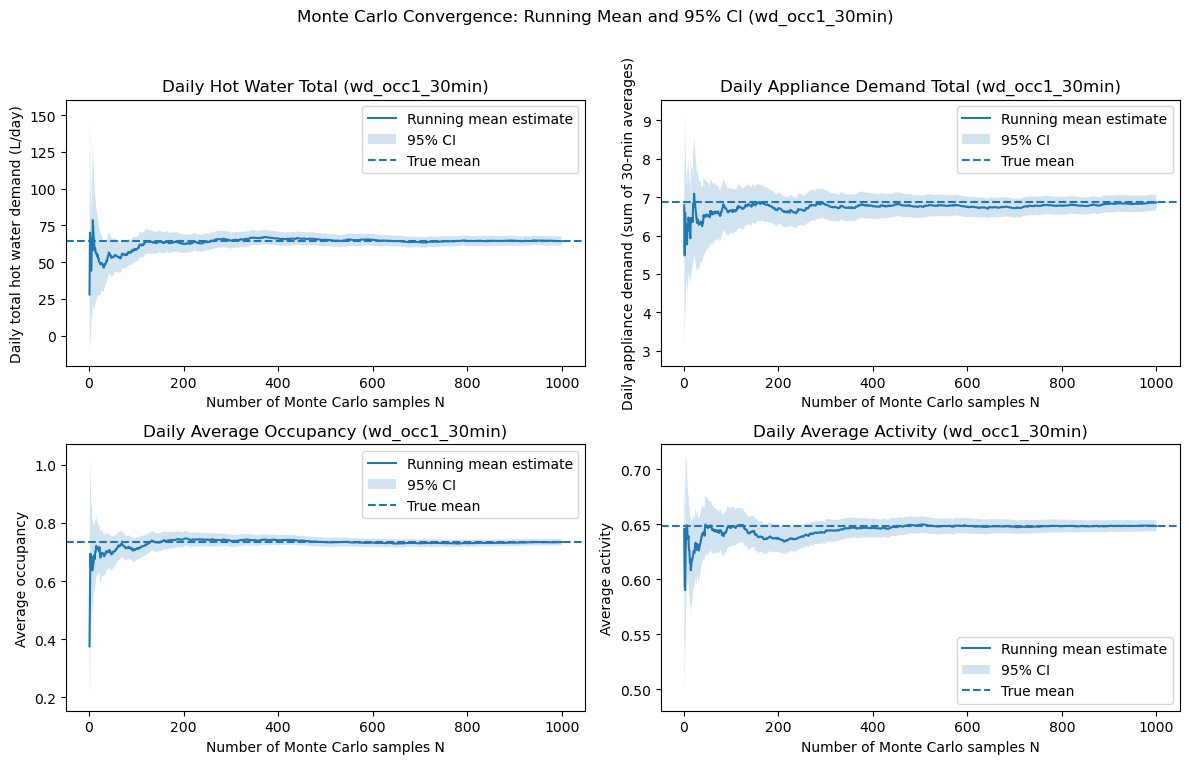

?? Saved convergence plot to: E:\GitHubProjects\LV network\Input data\Hotwater\crest_wd_occ1_30min_convergence.png


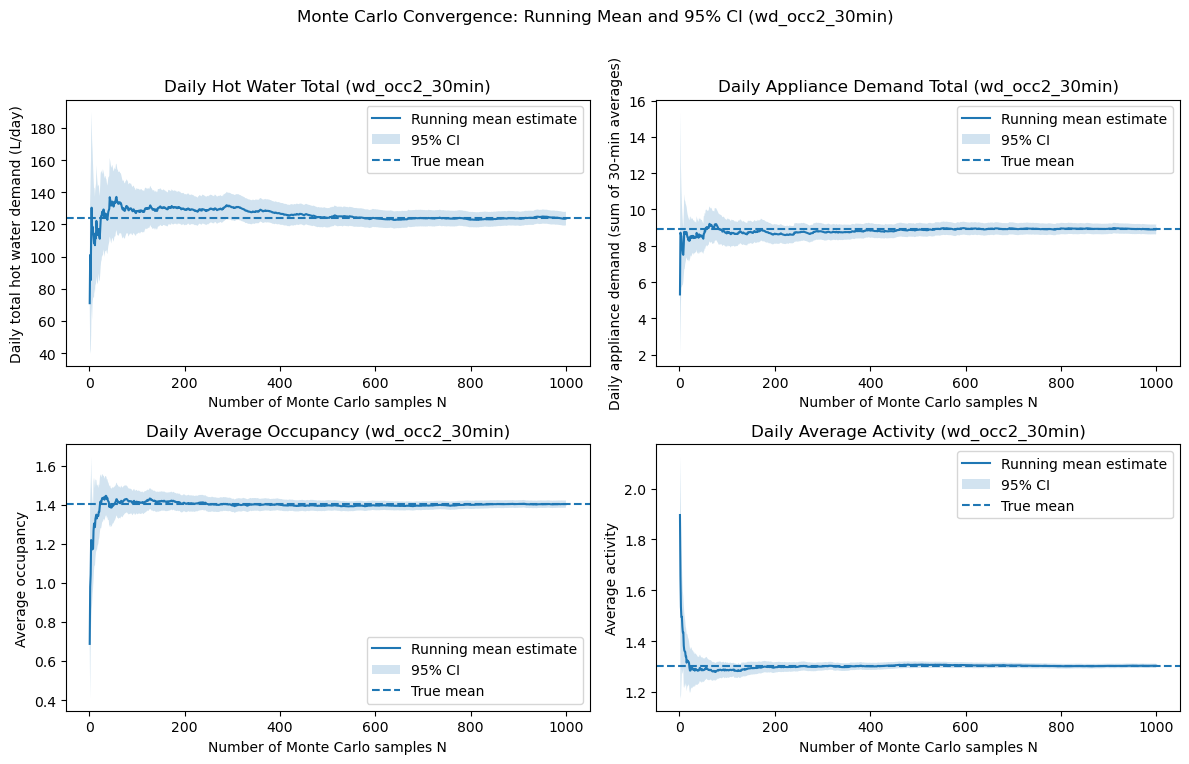

?? Saved convergence plot to: E:\GitHubProjects\LV network\Input data\Hotwater\crest_wd_occ2_30min_convergence.png


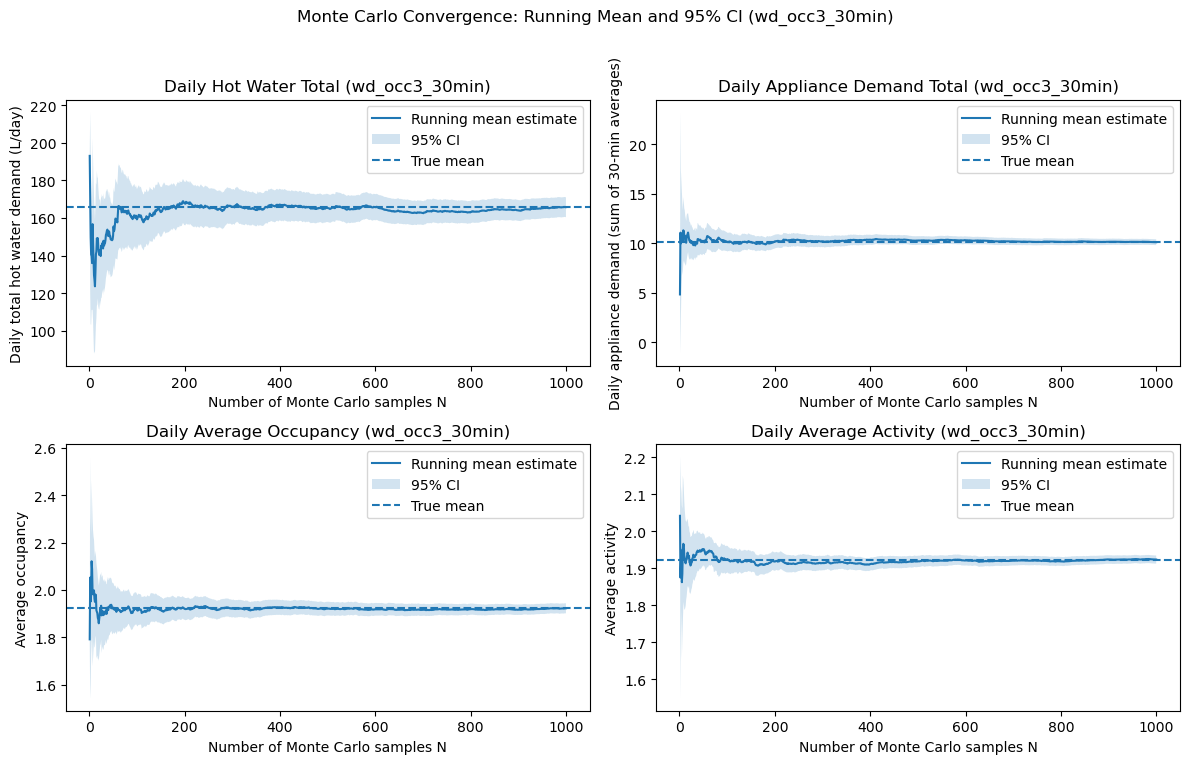

?? Saved convergence plot to: E:\GitHubProjects\LV network\Input data\Hotwater\crest_wd_occ3_30min_convergence.png


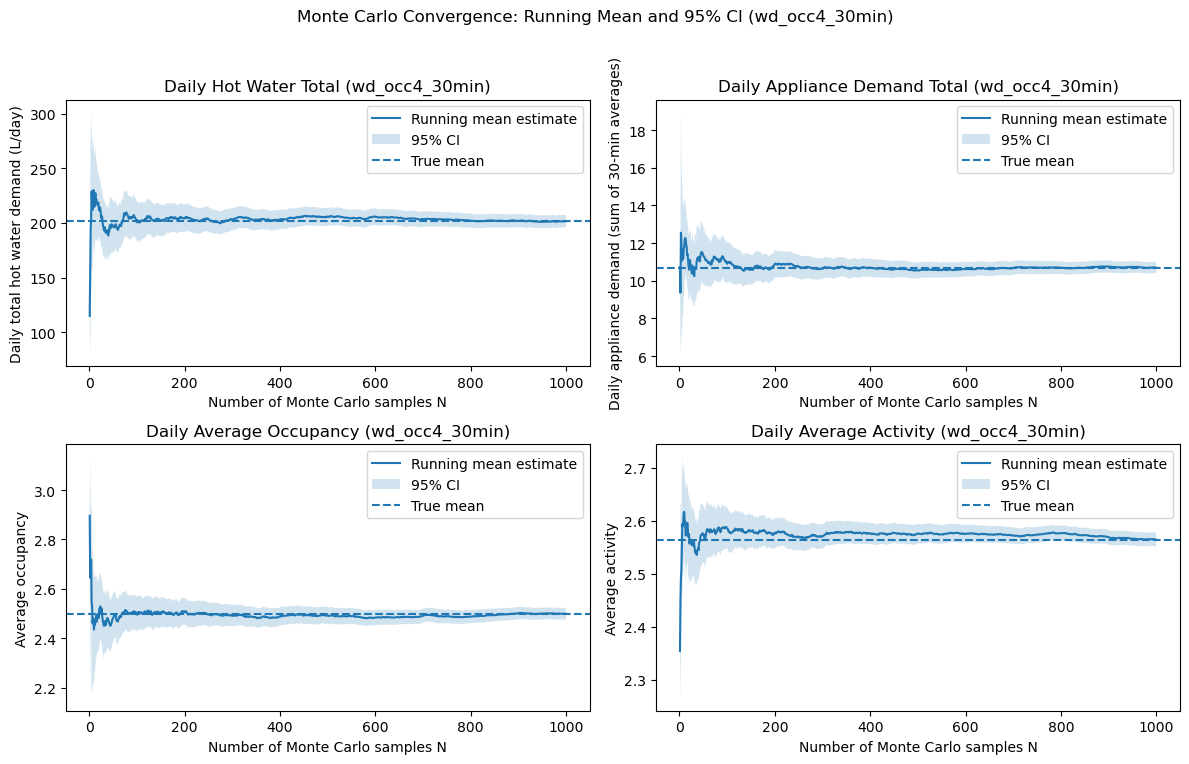

?? Saved convergence plot to: E:\GitHubProjects\LV network\Input data\Hotwater\crest_wd_occ4_30min_convergence.png


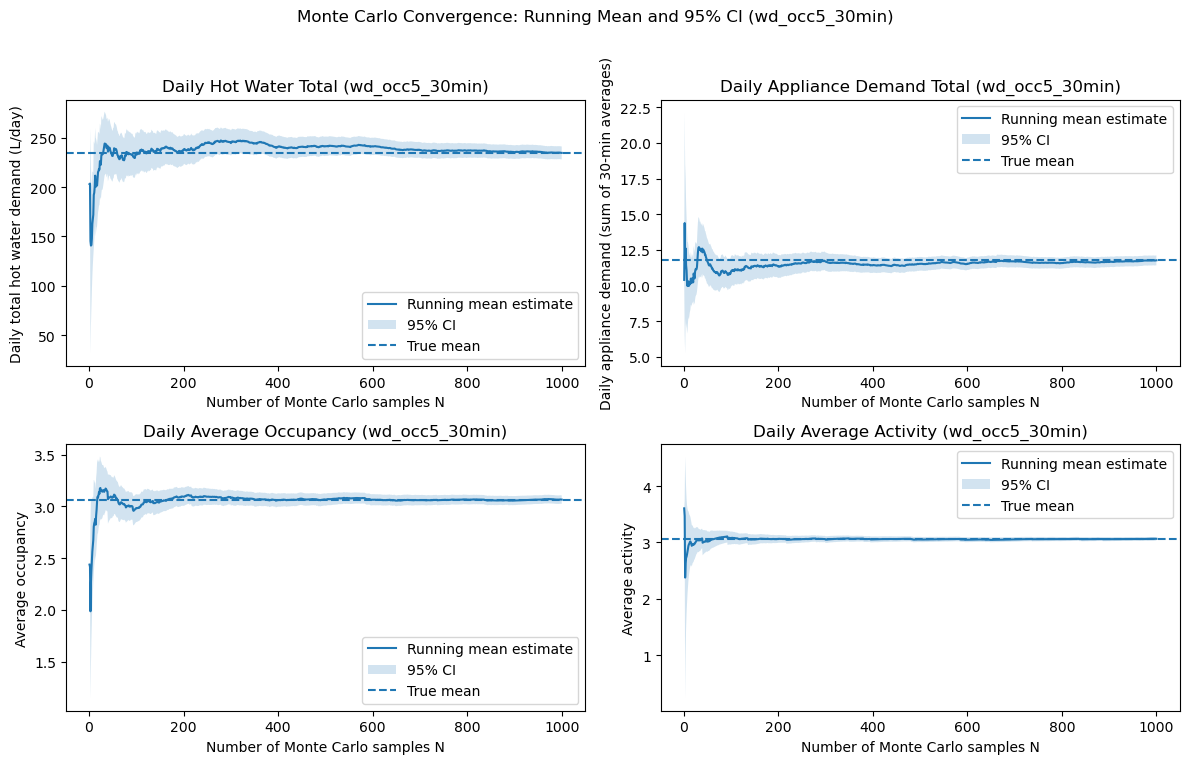

?? Saved convergence plot to: E:\GitHubProjects\LV network\Input data\Hotwater\crest_wd_occ5_30min_convergence.png


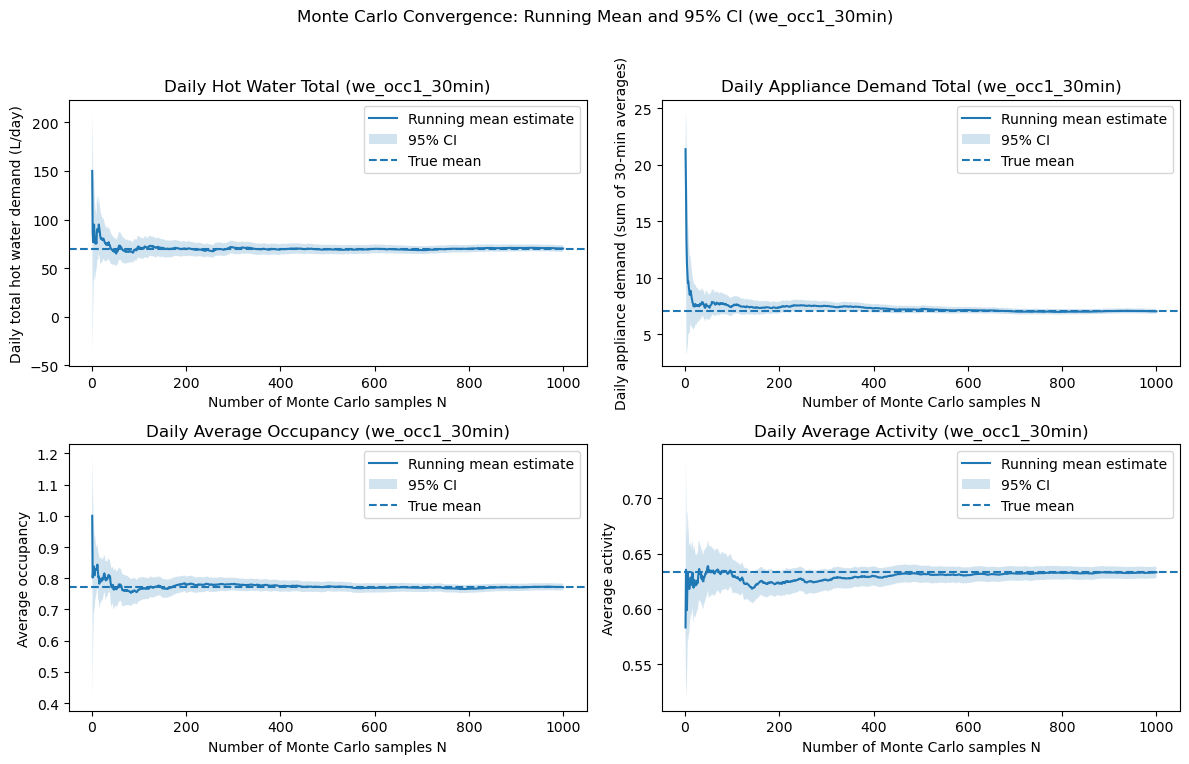

?? Saved convergence plot to: E:\GitHubProjects\LV network\Input data\Hotwater\crest_we_occ1_30min_convergence.png


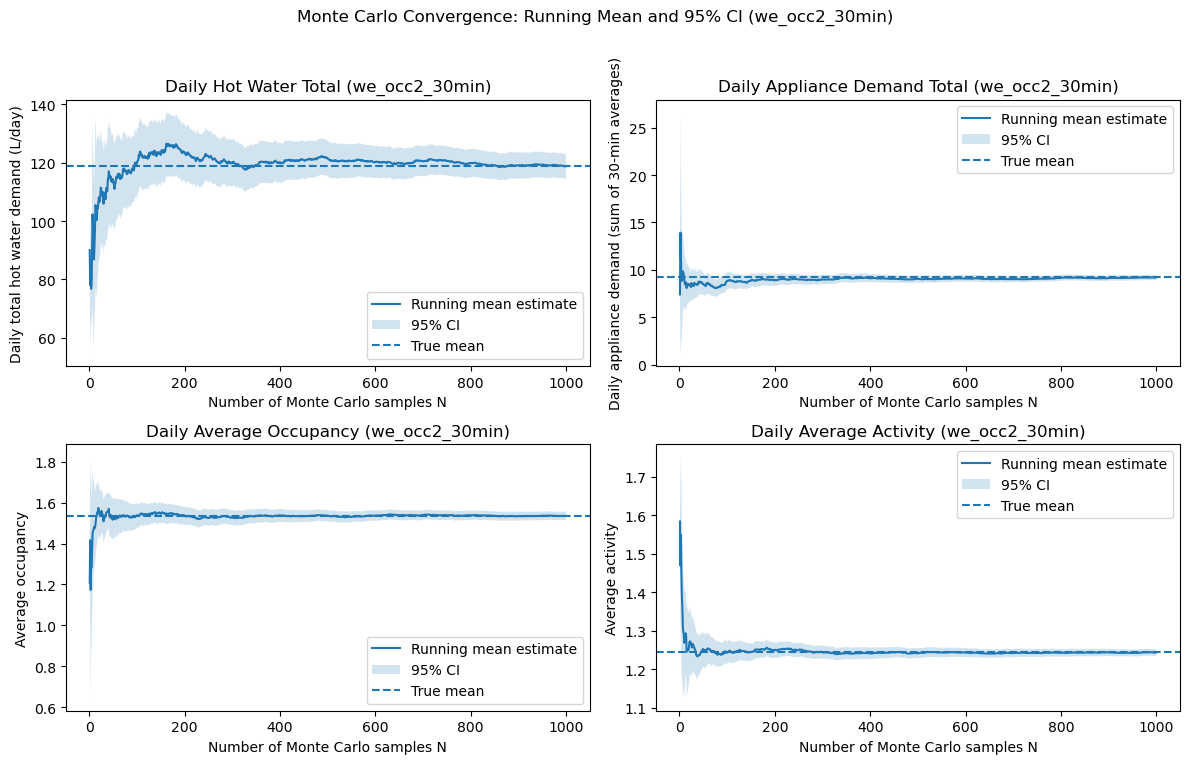

?? Saved convergence plot to: E:\GitHubProjects\LV network\Input data\Hotwater\crest_we_occ2_30min_convergence.png


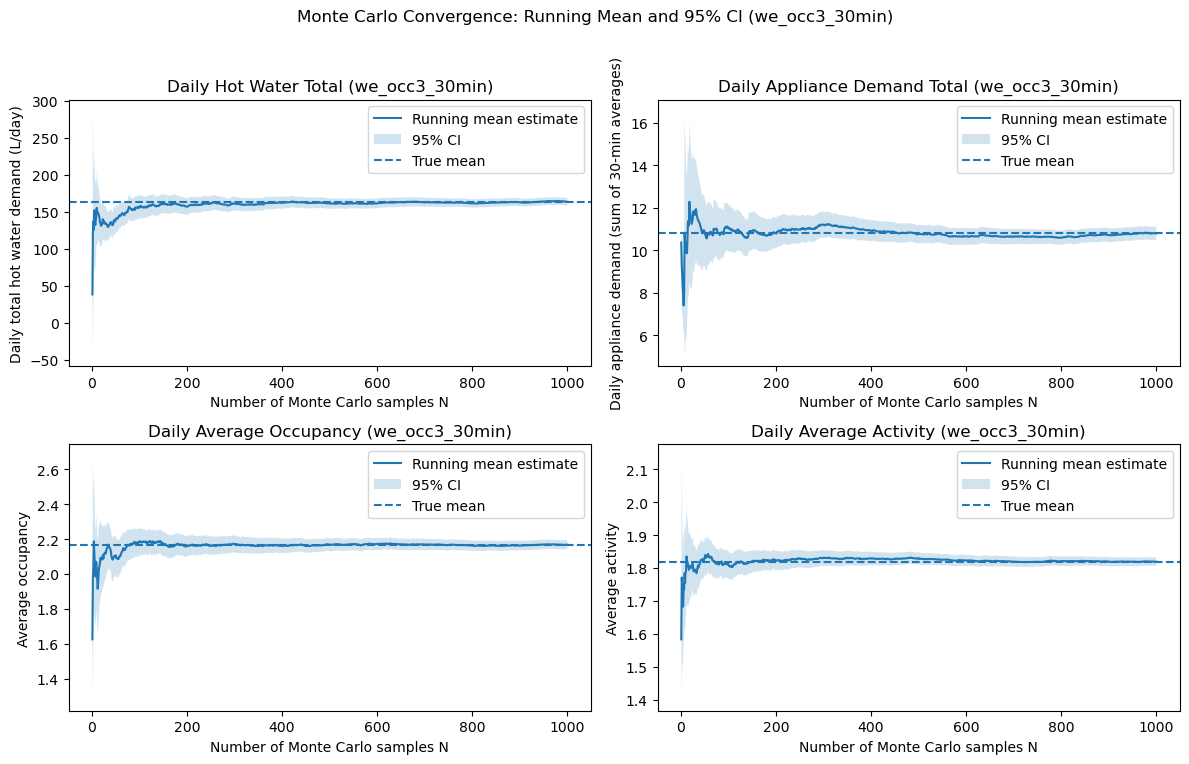

?? Saved convergence plot to: E:\GitHubProjects\LV network\Input data\Hotwater\crest_we_occ3_30min_convergence.png


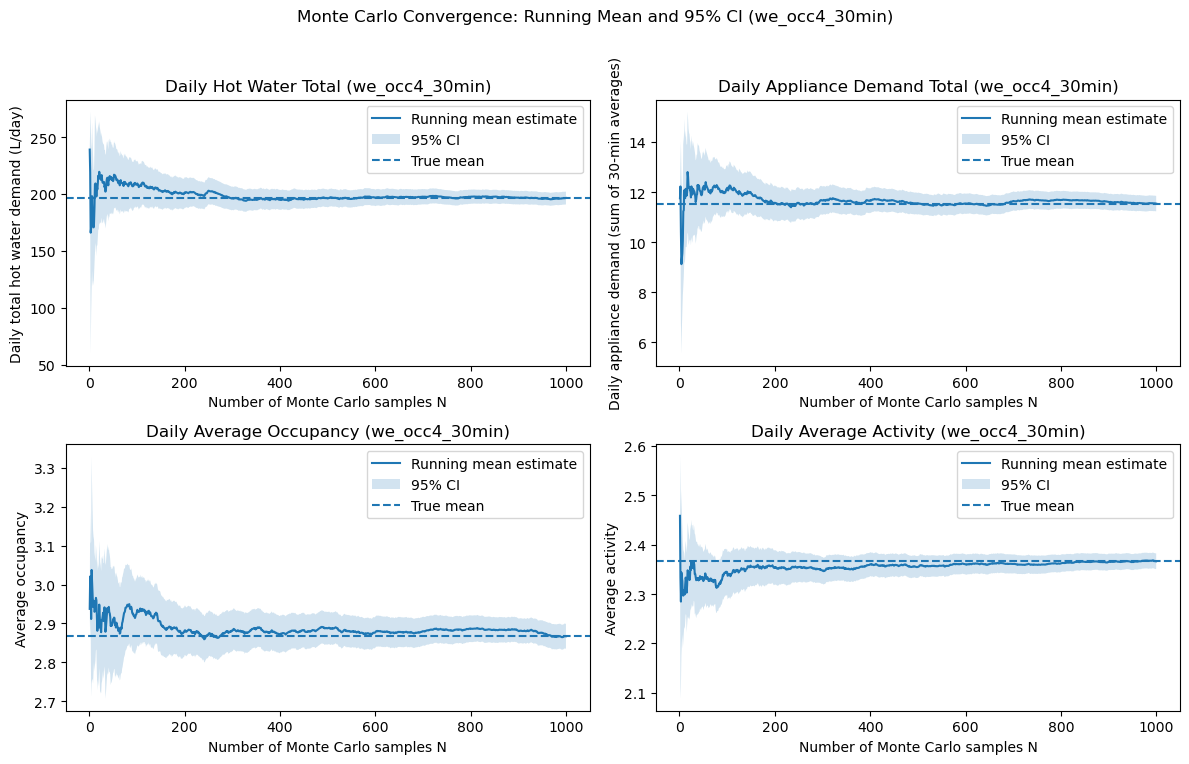

?? Saved convergence plot to: E:\GitHubProjects\LV network\Input data\Hotwater\crest_we_occ4_30min_convergence.png


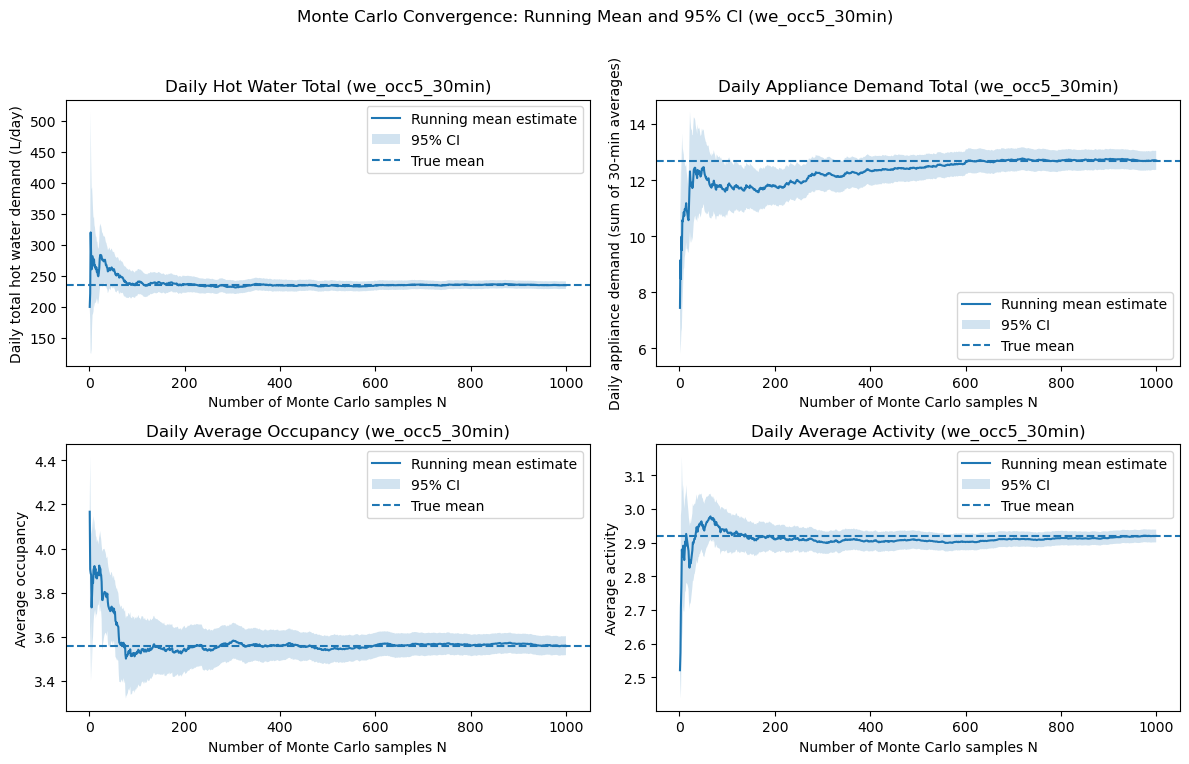

?? Saved convergence plot to: E:\GitHubProjects\LV network\Input data\Hotwater\crest_we_occ5_30min_convergence.png


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ================== CONFIG ==================
BASE_DIR = Path(
    r"E:\GitHubProjects\LV network\Input data\Hotwater"
)
INPUT_GLOB = "crest_*_30min.csv"
N_SAMPLES = 1000
# ============================================


def plot_convergence(ax: plt.Axes, samples: np.ndarray, title: str, ylabel: str) -> None:
    running_mean = np.cumsum(samples) / np.arange(1, len(samples) + 1)
    running_std = np.array(
        [np.std(samples[:i], ddof=1) if i > 1 else 0.0 for i in range(1, len(samples) + 1)]
    )
    ci_half_width = 1.96 * running_std / np.sqrt(np.arange(1, len(samples) + 1))
    true_mean = samples.mean()
    x = np.arange(1, len(samples) + 1)

    ax.plot(x, running_mean, label="Running mean estimate")
    ax.fill_between(
        x,
        running_mean - ci_half_width,
        running_mean + ci_half_width,
        alpha=0.2,
        label="95% CI",
    )
    ax.axhline(true_mean, linestyle="--", label="True mean")
    ax.set_title(title)
    ax.set_xlabel("Number of Monte Carlo samples N")
    ax.set_ylabel(ylabel)
    ax.legend()


input_files = sorted(BASE_DIR.glob(INPUT_GLOB))
if not input_files:
    raise FileNotFoundError(f"No input files matched {INPUT_GLOB} in {BASE_DIR}")

for input_file in input_files:
    df = pd.read_csv(input_file, index_col="time", parse_dates=True)

    hotwater_cols = [
        f"run_{i}_hotwater_L" for i in range(N_SAMPLES) if f"run_{i}_hotwater_L" in df.columns
    ]
    occupancy_cols = [
        f"run_{i}_occupancy" for i in range(N_SAMPLES) if f"run_{i}_occupancy" in df.columns
    ]
    activity_cols = [
        f"run_{i}_activity" for i in range(N_SAMPLES) if f"run_{i}_activity" in df.columns
    ]
    appliance_cols = [
        f"run_{i}_appliance_demand_W"
        for i in range(N_SAMPLES)
        if f"run_{i}_appliance_demand_W" in df.columns
    ]
    thermal_gains_cols = [
        f"run_{i}_Thermal Gains_W"
        for i in range(N_SAMPLES)
        if f"run_{i}_Thermal Gains_W" in df.columns
    ]

    if len(hotwater_cols) < N_SAMPLES:
        raise ValueError(f"Not enough Monte Carlo hot water columns in {input_file.name}")
    if len(occupancy_cols) < N_SAMPLES:
        raise ValueError(f"Not enough Monte Carlo occupancy columns in {input_file.name}")
    if len(activity_cols) < N_SAMPLES:
        raise ValueError(f"Not enough Monte Carlo activity columns in {input_file.name}")
    if len(appliance_cols) < N_SAMPLES:
        raise ValueError(f"Not enough Monte Carlo appliance demand columns in {input_file.name}")
    if len(thermal_gains_cols) < N_SAMPLES:
        raise ValueError(f"Not enough Monte Carlo thermal gains columns in {input_file.name}")

    # total daily hot water per run (L/day)    hotwater_totals = df[hotwater_cols].sum(axis=0).to_numpy()
    # total daily appliance demand per run (sum of 30-min averages)
    appliance_totals = df[appliance_cols].sum(axis=0).to_numpy()

    # daily average occupancy/activity per run
    occupancy_daily_avg = df[occupancy_cols].mean(axis=0).to_numpy()
    activity_daily_avg = df[activity_cols].mean(axis=0).to_numpy()

    fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=False)
    axes = axes.flatten()

    scenario_label = input_file.stem.replace("crest_", "")

    plot_convergence(
        axes[0],
        hotwater_totals,
        f"Daily Hot Water Total ({scenario_label})",
        "Daily total hot water demand (L/day)",
    )
    plot_convergence(
        axes[1],
        appliance_totals / 2000,
        f"Daily Appliance Demand Total ({scenario_label})",
        "Daily appliance demand (sum of 30-min averages)",
    )
    plot_convergence(
        axes[2],
        occupancy_daily_avg,
        f"Daily Average Occupancy ({scenario_label})",
        "Average occupancy",
    )
    plot_convergence(
        axes[3],
        activity_daily_avg,
        f"Daily Average Activity ({scenario_label})",
        "Average activity",
    )

    fig.suptitle(f"Monte Carlo Convergence: Running Mean and 95% CI ({scenario_label})")
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])

    output_path = input_file.with_name(f"{input_file.stem}_convergence.png")
    fig.savefig(output_path, dpi=300)
    plt.show()

    print(f"?? Saved convergence plot to: {output_path}")






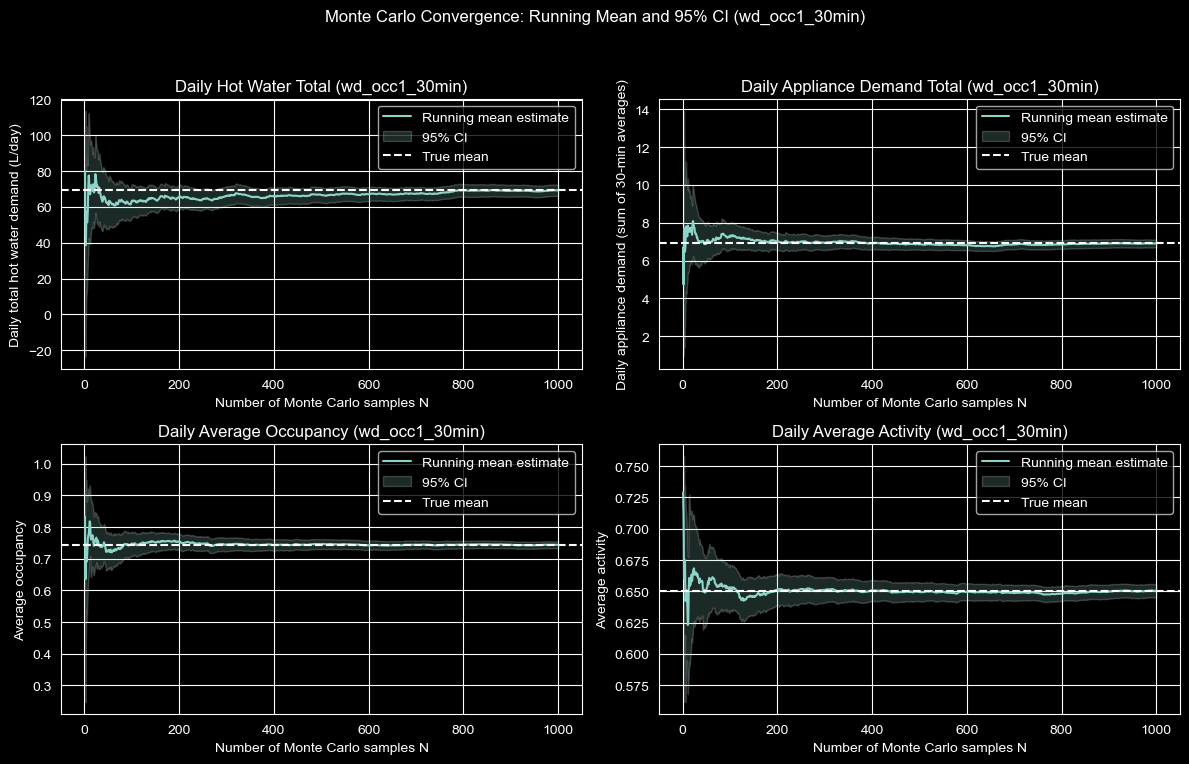

?? Saved convergence plot to: E:\GitHubProjects\LV network\Input data\Stochastic_Demands\crest_wd_occ1_30min_convergence.png
?? Saved EV availability output to: E:\GitHubProjects\LV network\Input data\Stochastic_Demands\Profiles\crest_wd_occ1_30min.csv


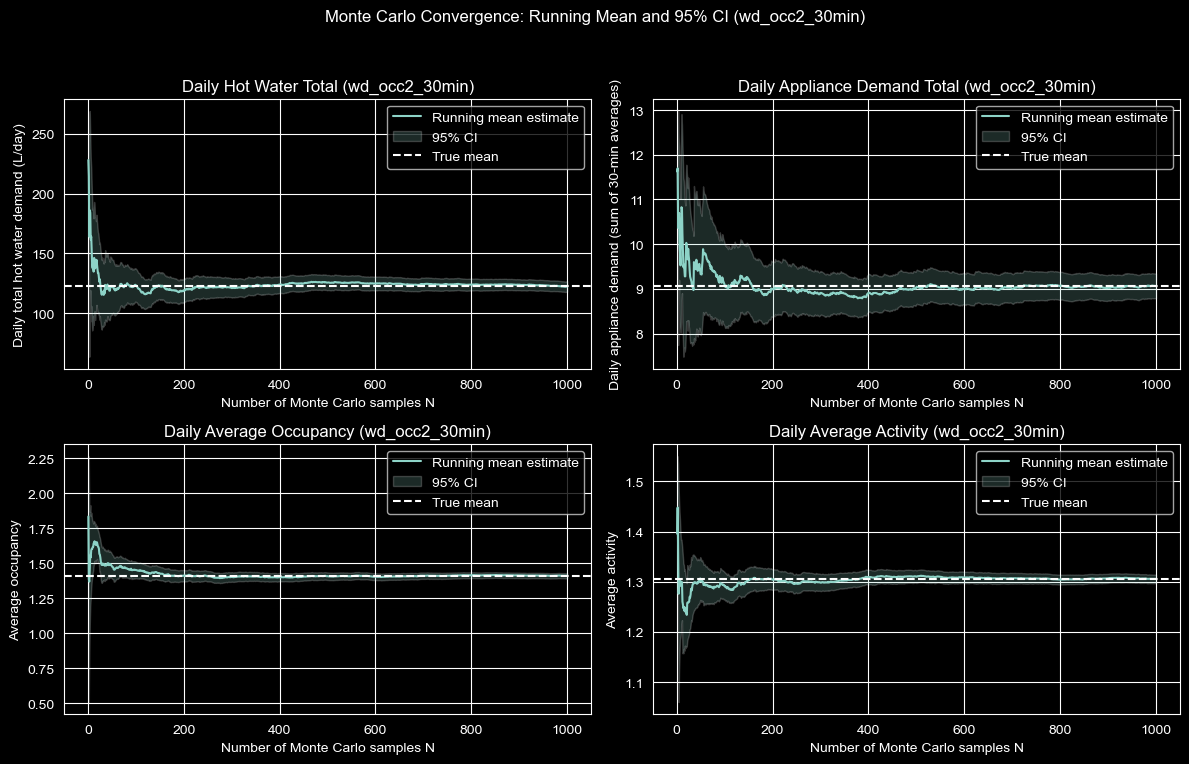

?? Saved convergence plot to: E:\GitHubProjects\LV network\Input data\Stochastic_Demands\crest_wd_occ2_30min_convergence.png
?? Saved EV availability output to: E:\GitHubProjects\LV network\Input data\Stochastic_Demands\Profiles\crest_wd_occ2_30min.csv


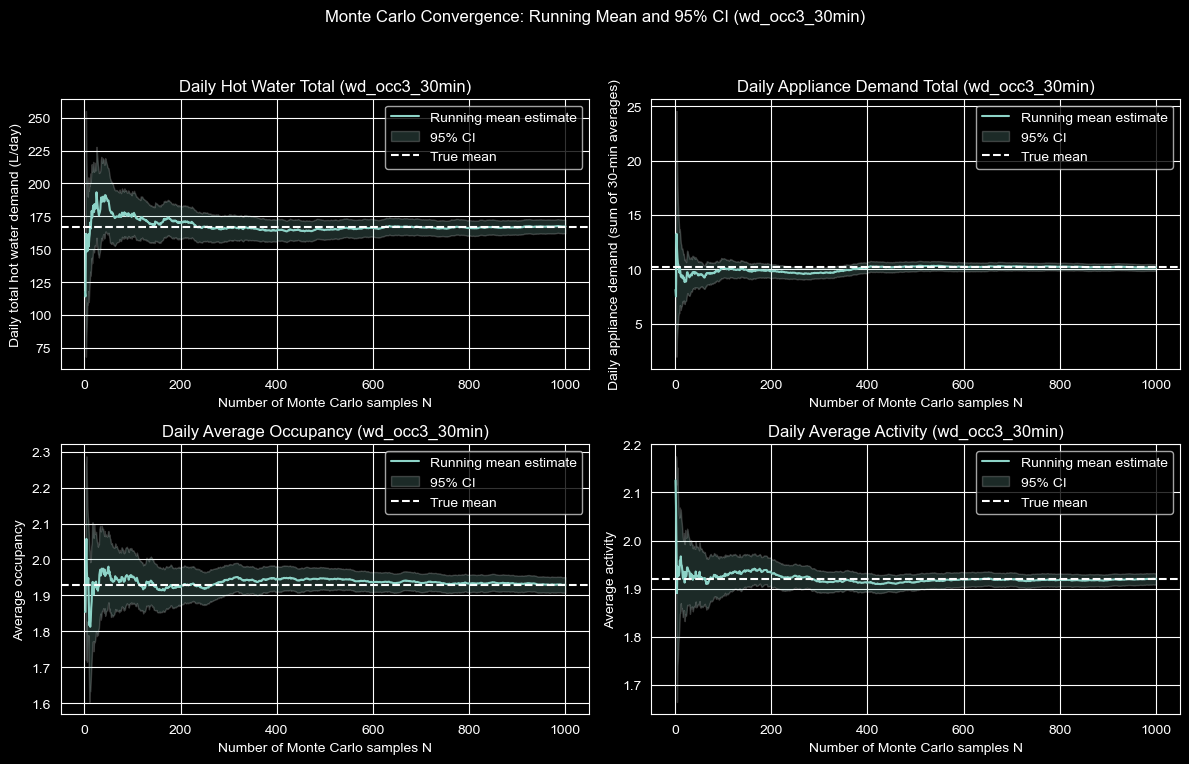

?? Saved convergence plot to: E:\GitHubProjects\LV network\Input data\Stochastic_Demands\crest_wd_occ3_30min_convergence.png
?? Saved EV availability output to: E:\GitHubProjects\LV network\Input data\Stochastic_Demands\Profiles\crest_wd_occ3_30min.csv


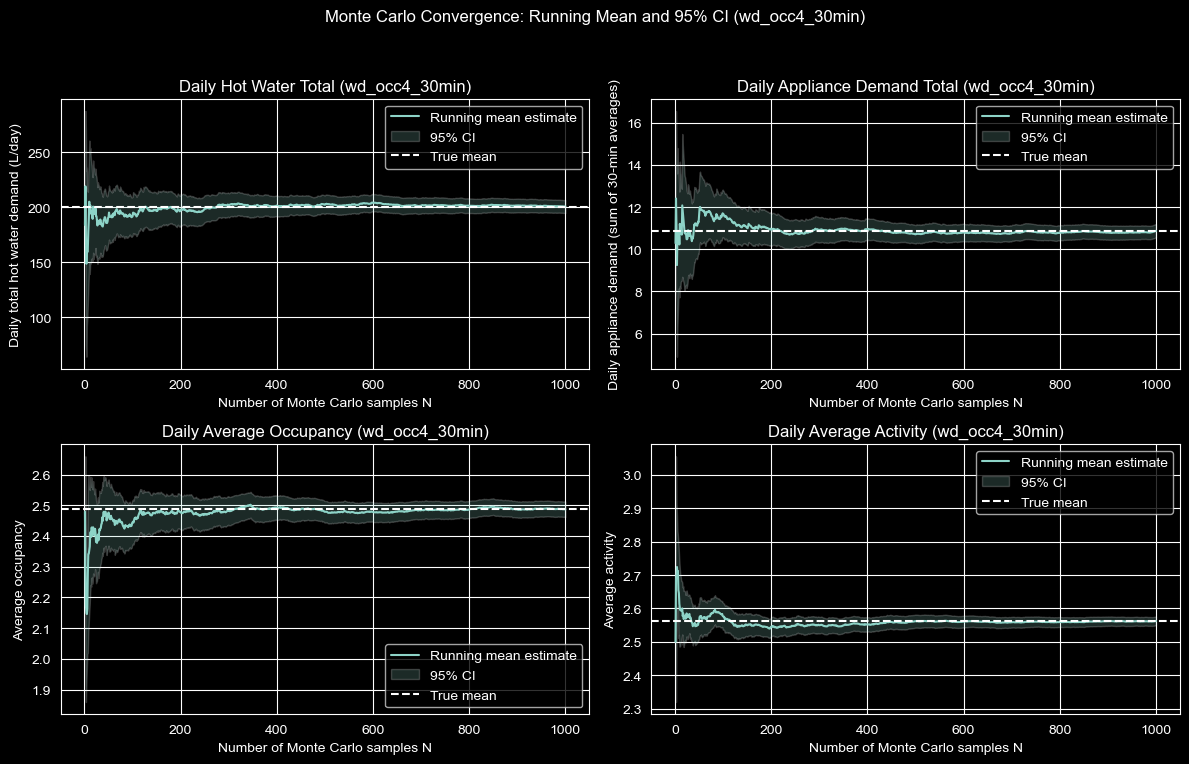

?? Saved convergence plot to: E:\GitHubProjects\LV network\Input data\Stochastic_Demands\crest_wd_occ4_30min_convergence.png
?? Saved EV availability output to: E:\GitHubProjects\LV network\Input data\Stochastic_Demands\Profiles\crest_wd_occ4_30min.csv


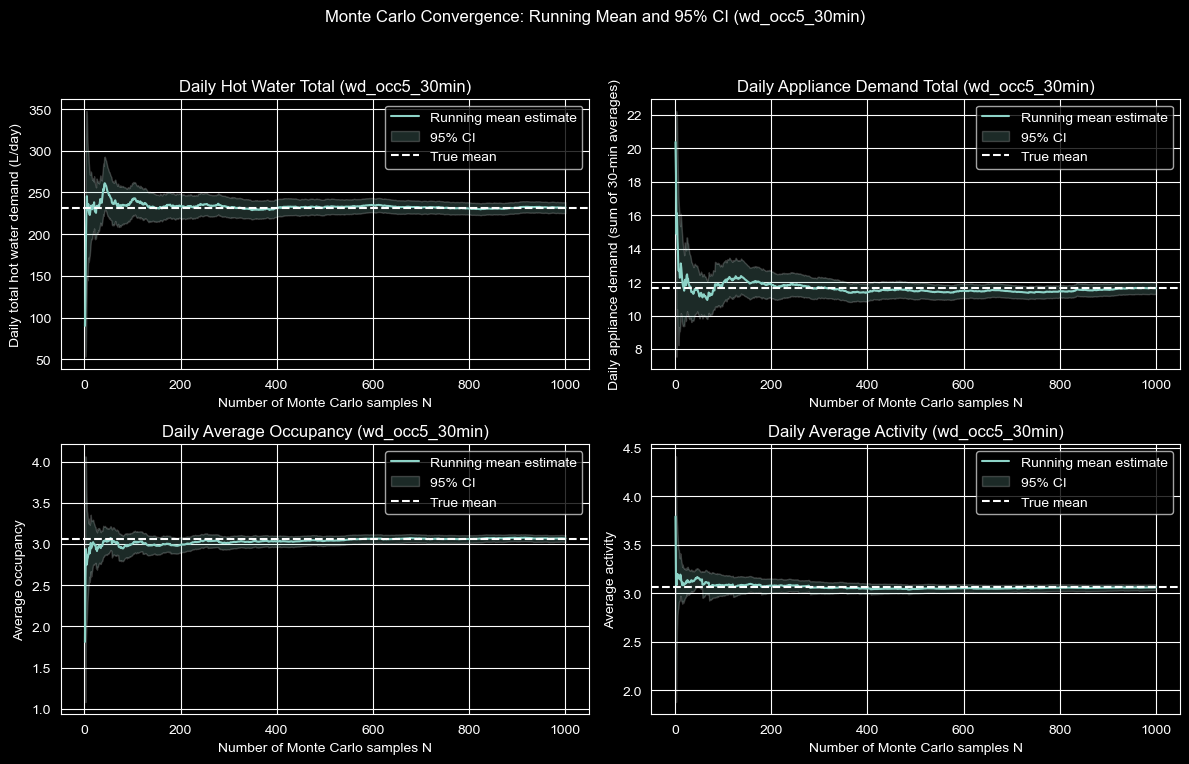

?? Saved convergence plot to: E:\GitHubProjects\LV network\Input data\Stochastic_Demands\crest_wd_occ5_30min_convergence.png
?? Saved EV availability output to: E:\GitHubProjects\LV network\Input data\Stochastic_Demands\Profiles\crest_wd_occ5_30min.csv


In [6]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ================== CONFIG ==================
BASE_DIR = Path(
    r"E:\GitHubProjects\LV network\Input data\Stochastic_Demands"
)
INPUT_GLOB = "crest_*_30min.csv"
EV_OUTPUT_DIR = BASE_DIR / "Profiles"
# ============================================


def plot_convergence(ax: plt.Axes, samples: np.ndarray, title: str, ylabel: str) -> None:
    running_mean = np.cumsum(samples) / np.arange(1, len(samples) + 1)
    running_std = np.array(
        [np.std(samples[:i], ddof=1) if i > 1 else 0.0 for i in range(1, len(samples) + 1)]
    )
    ci_half_width = 1.96 * running_std / np.sqrt(np.arange(1, len(samples) + 1))
    true_mean = samples.mean()
    x = np.arange(1, len(samples) + 1)

    ax.plot(x, running_mean, label="Running mean estimate")
    ax.fill_between(
        x,
        running_mean - ci_half_width,
        running_mean + ci_half_width,
        alpha=0.2,
        label="95% CI",
    )
    ax.axhline(true_mean, linestyle="--", label="True mean")
    ax.set_title(title)
    ax.set_xlabel("Number of Monte Carlo samples N")
    ax.set_ylabel(ylabel)
    ax.legend()


def build_ev_availability(occupancy_series: pd.Series) -> pd.Series:
    changes = occupancy_series.diff()
    first_departure = changes[changes < 0].index.min()
    last_arrival = changes[changes > 0].index.max()

    availability = pd.Series(1, index=occupancy_series.index, dtype=int)

    if pd.notna(first_departure):
        availability.loc[first_departure:] = 0

    if pd.notna(last_arrival):
        availability.loc[last_arrival:] = 1

    return availability


def extract_run_ids(columns: list[str]) -> list[int]:
    run_ids = []
    for name in columns:
        match = re.match(r"run_(\d+)_occupancy$", name)
        if match:
            run_ids.append(int(match.group(1)))
    return sorted(run_ids)


def build_ev_availability_df(df: pd.DataFrame, run_ids: list[int]) -> pd.DataFrame:
    availability = {
        f"run_{run_id}_ev_available": build_ev_availability(df[f"run_{run_id}_occupancy"])
        for run_id in run_ids
    }
    ev_df = pd.DataFrame(availability, index=df.index)
    ev_df.index.name = "time"
    return ev_df


input_files = sorted(BASE_DIR.glob(INPUT_GLOB))
if not input_files:
    raise FileNotFoundError(f"No input files matched {INPUT_GLOB} in {BASE_DIR}")

EV_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

for input_file in input_files:
    df = pd.read_csv(input_file, index_col="time", parse_dates=True)

    run_ids = extract_run_ids(df.columns.tolist())
    if not run_ids:
        raise ValueError(f"No occupancy runs found in {input_file.name}")

    hotwater_cols = [f"run_{run_id}_hotwater_L" for run_id in run_ids]
    occupancy_cols = [f"run_{run_id}_occupancy" for run_id in run_ids]
    activity_cols = [f"run_{run_id}_activity" for run_id in run_ids]
    appliance_cols = [f"run_{run_id}_appliance_demand_W" for run_id in run_ids]

    missing = [
        name
        for name in hotwater_cols + occupancy_cols + activity_cols + appliance_cols
        if name not in df.columns
    ]
    if missing:
        raise ValueError(f"Missing columns in {input_file.name}: {missing}")

    # total daily hot water per run (L/day)
    hotwater_totals = df[hotwater_cols].sum(axis=0).to_numpy()

    # total daily appliance demand per run (sum of 30-min averages)
    appliance_totals = df[appliance_cols].sum(axis=0).to_numpy()

    # daily average occupancy/activity per run
    occupancy_daily_avg = df[occupancy_cols].mean(axis=0).to_numpy()
    activity_daily_avg = df[activity_cols].mean(axis=0).to_numpy()

    fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=False)
    axes = axes.flatten()

    scenario_label = input_file.stem.replace("crest_", "")

    plot_convergence(
        axes[0],
        hotwater_totals,
        f"Daily Hot Water Total ({scenario_label})",
        "Daily total hot water demand (L/day)",
    )
    plot_convergence(
        axes[1],
        appliance_totals / 2000,
        f"Daily Appliance Demand Total ({scenario_label})",
        "Daily appliance demand (sum of 30-min averages)",
    )
    plot_convergence(
        axes[2],
        occupancy_daily_avg,
        f"Daily Average Occupancy ({scenario_label})",
        "Average occupancy",
    )
    plot_convergence(
        axes[3],
        activity_daily_avg,
        f"Daily Average Activity ({scenario_label})",
        "Average activity",
    )

    fig.suptitle(f"Monte Carlo Convergence: Running Mean and 95% CI ({scenario_label})")
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])

    output_path = input_file.with_name(f"{input_file.stem}_convergence.png")
    fig.savefig(output_path, dpi=300)
    plt.show()

    print(f"?? Saved convergence plot to: {output_path}")

    ev_availability = build_ev_availability_df(df, run_ids)
    df_with_ev = pd.concat([df, ev_availability], axis=1)

    ev_output_path = EV_OUTPUT_DIR / input_file.name
    df_with_ev.to_csv(ev_output_path)
    print(f"?? Saved EV availability output to: {ev_output_path}")

# This block is used to generate stochastic mileage of EV


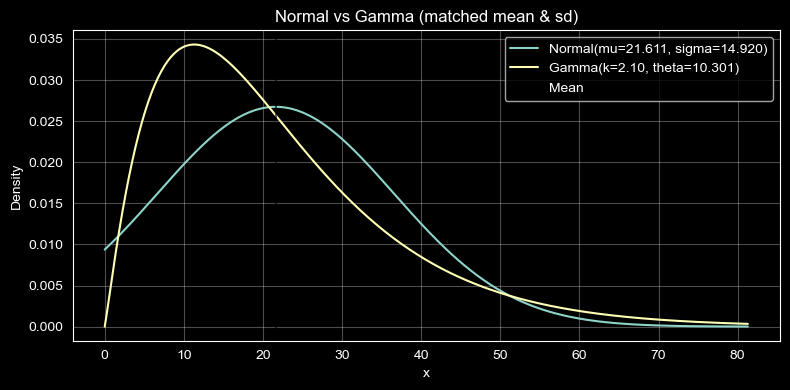

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import math

mean = 2.61 * 8.28
standard_deviation = 14.92

x = np.linspace(0.0, mean + 4 * standard_deviation, 400)
normal_pdf = (1 / (standard_deviation * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / standard_deviation) ** 2)

# Gamma with same mean/sd (stable log-pdf)
shape = (mean / standard_deviation) ** 2
scale = (standard_deviation ** 2) / mean
x_safe = np.where(x <= 0, 1e-12, x)
log_pdf = (shape - 1) * np.log(x_safe) - x_safe / scale - shape * np.log(scale) - math.lgamma(shape)
# avoid under/overflow
log_pdf = np.clip(log_pdf, -700, 700)
gamma_pdf = np.exp(log_pdf)
# enforce gamma at x=0 to 0 when shape>1
if shape > 1:
    gamma_pdf[0] = 0.0

plt.figure(figsize=(8, 4))
plt.plot(x, normal_pdf, label=f"Normal(mu={mean:.3f}, sigma={standard_deviation:.3f})")
plt.plot(x, gamma_pdf, label=f"Gamma(k={shape:.2f}, theta={scale:.3f})")
plt.axvline(mean, color='k', linestyle='--', alpha=0.6, label='Mean')
plt.title('Normal vs Gamma (matched mean & sd)')
plt.xlabel('x')
plt.ylabel('Density')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

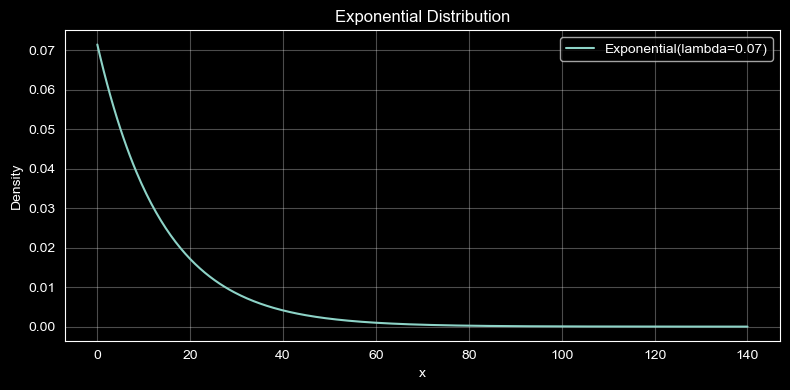

In [5]:
import numpy as np
import matplotlib.pyplot as plt

rate = 1/14  # lambda
x = np.linspace(0, 10 / rate, 400)
pdf = rate * np.exp(-rate * x)

plt.figure(figsize=(8, 4))
plt.plot(x, pdf, label=f"Exponential(lambda={rate:.2f})")
plt.title('Exponential Distribution')
plt.xlabel('x')
plt.ylabel('Density')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()